### Build Linear Conditional GAN to generate synthetic cifar 10 data
Traditional Conditional GAN label embedding: embed labels to both generator and discriminator

In [74]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [76]:
training_parameters = {
    "n_epochs": 100,
    "batch_size": 100,
}
data_loader = torch.utils.data.DataLoader(
  
datasets.MNIST('./', train=True, download=True,
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(
                             (0.5,), (0.5,))
                         ])),
batch_size=training_parameters["batch_size"], shuffle=True)

In [77]:
num_batches = len(data_loader)
print("Number of batches: ",num_batches)

Number of batches:  600


torch.Size([100, 1, 28, 28])


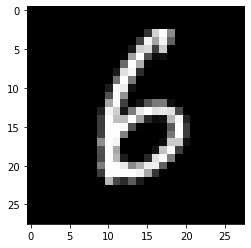

In [78]:
%matplotlib inline 
from matplotlib import pyplot as plt

for x,_ in data_loader:
    print(x.shape)
    plt.imshow(x.numpy()[0][0], cmap='gray')
    break

In [79]:
class GeneratorModel1(nn.Module):
    def __init__(self):
        super(GeneratorModel1, self).__init__()
        input_dim = 100 + 10
        output_dim = 784
        self.label_embedding = nn.Embedding(10, 10)
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        
        # label embedding[100, 1]
        # input image [100, 1]
        # out = cat([label, input], axis=0) # [100, 2]
        # // another way
        # out = label + input # [100 ,1]
        
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)
    
class GeneratorModel2(nn.Module):
    def __init__(self):
        super(GeneratorModel2, self).__init__()
        input_dim = 100
        output_dim = 784
        self.label_embedding = nn.Embedding(10, 100)
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = x + c
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)
    
class GeneratorModel3(nn.Module):
    def __init__(self):
        super(GeneratorModel3, self).__init__()
        input_dim = 100 + 100
        output_dim = 784
        self.label_embedding = nn.Embedding(10, 10)
        self.l1 = nn.Linear(10, 100)
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        c = self.l1(c)
#         print(f'c shape is {c.shape}') # bh, 100
        x = torch.cat([x, c], 1)
#         print(f'x.shape is {x.shape}') # bh, 200
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
#         print(output.shape) # bh, 784
        return output.to(device)

class GeneratorModel4(nn.Module):
    def __init__(self):
        super(GeneratorModel4, self).__init__()
        input_dim = 100 + 100
        output_dim = 784
        self.label_embedding = nn.Embedding(10, 100)
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, x, labels):
        c = self.label_embedding(labels)
#         print(f'c shape is {c.shape}') # bh, 100
        x = torch.cat([x, c], 1)
#         print(f'x.shape is {x.shape}') # bh, 200
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
#         print(output.shape) # bh, 784
        return output.to(device)

In [80]:
class DiscriminatorModel1(nn.Module):
    def __init__(self):
        super(DiscriminatorModel1, self).__init__()
        input_dim = 784 + 10
        output_dim = 1
        self.label_embedding = nn.Embedding(10, 10)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)
    
class DiscriminatorModel2(nn.Module):
    def __init__(self):
        super(DiscriminatorModel2, self).__init__()
        input_dim = 784 + 100
        output_dim = 1
        self.label_embedding = nn.Embedding(10, 100)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)
    
#wrong
class DiscriminatorModel3(nn.Module):
    def __init__(self):
        super(DiscriminatorModel3, self).__init__()
        input_dim = 784
        output_dim = 1
        self.label_embedding = nn.Embedding(10, 10)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = x + c
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)

In [81]:
discriminator1 = DiscriminatorModel1()
discriminator2 = DiscriminatorModel2()
discriminator3 = DiscriminatorModel3()
generator1 = GeneratorModel1()
generator2 = GeneratorModel2()
generator3 = GeneratorModel3()
generator4 = GeneratorModel4()

discriminator1.to(device) 
discriminator2.to(device) 
discriminator3.to(device) 
generator1.to(device)
generator2.to(device)
generator3.to(device)
generator4.to(device);

In [82]:
def train(generator, discriminator, data_loader, model_name='model_name'):
    n_epochs = training_parameters["n_epochs"]
    batch_size = training_parameters["batch_size"]

    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

    loss = nn.BCELoss()
    
    for epoch_idx in range(n_epochs):
        G_loss = []
        D_loss = []
        for batch_idx, data_input in enumerate(data_loader):


            noise = torch.randn(batch_size,100).to(device)
            fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
            generated_data = generator(noise, fake_labels) # batch_size X 784


            # Discriminator
            true_data = data_input[0].view(batch_size, 784).to(device) # batch_size X 784
            digit_labels = data_input[1].to(device) # batch_size
            true_labels = torch.ones(batch_size).to(device)

            discriminator_optimizer.zero_grad()

            discriminator_output_for_true_data = discriminator(true_data, digit_labels).view(batch_size)
            true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

            discriminator_output_for_generated_data = discriminator(generated_data.detach(), fake_labels).view(batch_size)
            generator_discriminator_loss = loss(
                discriminator_output_for_generated_data, torch.zeros(batch_size).to(device)
            )
            discriminator_loss = (
                true_discriminator_loss + generator_discriminator_loss
            ) / 2

            discriminator_loss.backward()
            discriminator_optimizer.step()

            D_loss.append(discriminator_loss.data.item())


            # Generator

            generator_optimizer.zero_grad()
            # It's a choice to generate the data again
            generated_data = generator(noise, fake_labels) # batch_size X 784
            discriminator_output_on_generated_data = discriminator(generated_data, fake_labels).view(batch_size)
            generator_loss = loss(discriminator_output_on_generated_data, true_labels)
            generator_loss.backward()
            generator_optimizer.step()

            G_loss.append(generator_loss.data.item())
            if ((batch_idx + 1)% 500 == 0 and (epoch_idx + 1)%10 == 0):
                print("Training Steps Completed: ", batch_idx)

                with torch.no_grad():
                    noise = torch.randn(batch_size,100).to(device)
                    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
                    generated_data = generator(noise, fake_labels).cpu().view(batch_size, 28, 28)
                    for x in generated_data:
                        print(fake_labels[0].item())
                        plt.imshow(x.detach().numpy(), interpolation='nearest',cmap='gray')
                        plt.show()

                        break


        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
        
        torch.save(generator, f'./{model_name}.pt')

In [92]:
#load model and generate 0 - 9 images
def draw_images(model_name):
    generator = torch.load(model_name)
    with torch.no_grad():
        noise = torch.randn(10,100).to(device)
        labels = torch.IntTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
#         labels = torch.range(0, 9)
        generated_data = generator(noise, labels).cpu().view(10, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(20,2))
    for i in range(10):
        axs[i].imshow(generated_data[i].detach().numpy(), interpolation='nearest',cmap='gray')
    fig.savefig(f'{model_name}_syn.pdf')

[0/100]: loss_d: 0.513, loss_g: 2.431
[1/100]: loss_d: 0.636, loss_g: 1.348
[2/100]: loss_d: 0.505, loss_g: 1.530
[3/100]: loss_d: 0.294, loss_g: 2.600
[4/100]: loss_d: 0.259, loss_g: 2.676
[5/100]: loss_d: 0.264, loss_g: 2.677
[6/100]: loss_d: 0.267, loss_g: 2.867
[7/100]: loss_d: 0.226, loss_g: 3.050
[8/100]: loss_d: 0.266, loss_g: 2.789
Training Steps Completed:  499
0


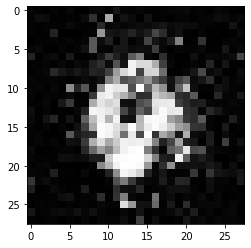

[9/100]: loss_d: 0.285, loss_g: 2.646
[10/100]: loss_d: 0.299, loss_g: 2.541
[11/100]: loss_d: 0.300, loss_g: 2.494
[12/100]: loss_d: 0.322, loss_g: 2.429
[13/100]: loss_d: 0.349, loss_g: 2.248
[14/100]: loss_d: 0.370, loss_g: 2.095
[15/100]: loss_d: 0.386, loss_g: 1.996
[16/100]: loss_d: 0.401, loss_g: 1.912
[17/100]: loss_d: 0.403, loss_g: 1.872
[18/100]: loss_d: 0.425, loss_g: 1.789
Training Steps Completed:  499
5


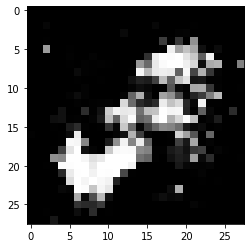

[19/100]: loss_d: 0.432, loss_g: 1.744
[20/100]: loss_d: 0.443, loss_g: 1.688
[21/100]: loss_d: 0.462, loss_g: 1.597
[22/100]: loss_d: 0.471, loss_g: 1.554
[23/100]: loss_d: 0.466, loss_g: 1.568
[24/100]: loss_d: 0.481, loss_g: 1.511
[25/100]: loss_d: 0.502, loss_g: 1.406
[26/100]: loss_d: 0.502, loss_g: 1.417
[27/100]: loss_d: 0.506, loss_g: 1.405
[28/100]: loss_d: 0.516, loss_g: 1.348
Training Steps Completed:  499
1


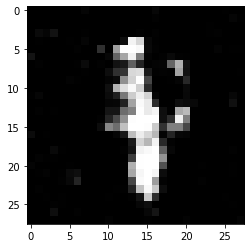

[29/100]: loss_d: 0.527, loss_g: 1.313
[30/100]: loss_d: 0.522, loss_g: 1.340
[31/100]: loss_d: 0.544, loss_g: 1.254
[32/100]: loss_d: 0.535, loss_g: 1.270
[33/100]: loss_d: 0.548, loss_g: 1.227
[34/100]: loss_d: 0.549, loss_g: 1.223
[35/100]: loss_d: 0.544, loss_g: 1.242
[36/100]: loss_d: 0.556, loss_g: 1.201
[37/100]: loss_d: 0.558, loss_g: 1.188
[38/100]: loss_d: 0.573, loss_g: 1.137
Training Steps Completed:  499
0


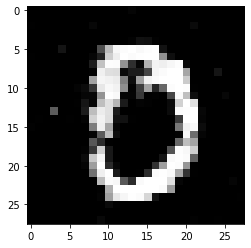

[39/100]: loss_d: 0.572, loss_g: 1.147
[40/100]: loss_d: 0.570, loss_g: 1.135
[41/100]: loss_d: 0.579, loss_g: 1.106
[42/100]: loss_d: 0.580, loss_g: 1.102
[43/100]: loss_d: 0.590, loss_g: 1.081
[44/100]: loss_d: 0.585, loss_g: 1.083
[45/100]: loss_d: 0.590, loss_g: 1.074
[46/100]: loss_d: 0.601, loss_g: 1.030
[47/100]: loss_d: 0.599, loss_g: 1.031
[48/100]: loss_d: 0.594, loss_g: 1.054
Training Steps Completed:  499
0


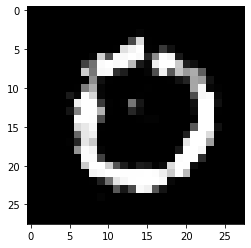

[49/100]: loss_d: 0.595, loss_g: 1.045
[50/100]: loss_d: 0.596, loss_g: 1.038
[51/100]: loss_d: 0.600, loss_g: 1.023
[52/100]: loss_d: 0.609, loss_g: 0.997
[53/100]: loss_d: 0.597, loss_g: 1.042
[54/100]: loss_d: 0.594, loss_g: 1.054
[55/100]: loss_d: 0.605, loss_g: 1.015
[56/100]: loss_d: 0.605, loss_g: 1.017
[57/100]: loss_d: 0.609, loss_g: 0.997
[58/100]: loss_d: 0.609, loss_g: 0.994
Training Steps Completed:  499
9


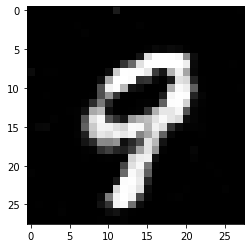

[59/100]: loss_d: 0.615, loss_g: 0.975
[60/100]: loss_d: 0.623, loss_g: 0.940
[61/100]: loss_d: 0.621, loss_g: 0.949
[62/100]: loss_d: 0.616, loss_g: 0.972
[63/100]: loss_d: 0.613, loss_g: 0.974
[64/100]: loss_d: 0.615, loss_g: 0.976
[65/100]: loss_d: 0.620, loss_g: 0.965
[66/100]: loss_d: 0.622, loss_g: 0.951
[67/100]: loss_d: 0.622, loss_g: 0.954
[68/100]: loss_d: 0.620, loss_g: 0.945
Training Steps Completed:  499
8


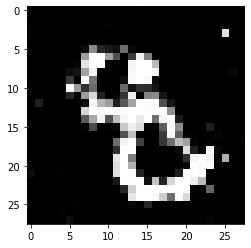

[69/100]: loss_d: 0.627, loss_g: 0.933
[70/100]: loss_d: 0.630, loss_g: 0.919
[71/100]: loss_d: 0.627, loss_g: 0.943
[72/100]: loss_d: 0.630, loss_g: 0.920
[73/100]: loss_d: 0.628, loss_g: 0.930
[74/100]: loss_d: 0.630, loss_g: 0.923
[75/100]: loss_d: 0.632, loss_g: 0.907
[76/100]: loss_d: 0.629, loss_g: 0.928
[77/100]: loss_d: 0.628, loss_g: 0.931
[78/100]: loss_d: 0.628, loss_g: 0.922
Training Steps Completed:  499
1


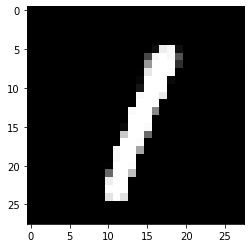

[79/100]: loss_d: 0.624, loss_g: 0.938
[80/100]: loss_d: 0.629, loss_g: 0.921
[81/100]: loss_d: 0.635, loss_g: 0.911
[82/100]: loss_d: 0.634, loss_g: 0.905
[83/100]: loss_d: 0.641, loss_g: 0.881
[84/100]: loss_d: 0.639, loss_g: 0.896
[85/100]: loss_d: 0.637, loss_g: 0.899
[86/100]: loss_d: 0.638, loss_g: 0.893
[87/100]: loss_d: 0.638, loss_g: 0.901
[88/100]: loss_d: 0.639, loss_g: 0.893
Training Steps Completed:  499
8


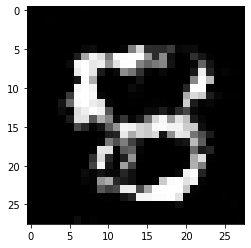

[89/100]: loss_d: 0.645, loss_g: 0.866
[90/100]: loss_d: 0.645, loss_g: 0.871
[91/100]: loss_d: 0.640, loss_g: 0.900
[92/100]: loss_d: 0.638, loss_g: 0.890
[93/100]: loss_d: 0.645, loss_g: 0.869
[94/100]: loss_d: 0.644, loss_g: 0.880
[95/100]: loss_d: 0.639, loss_g: 0.903
[96/100]: loss_d: 0.635, loss_g: 0.905
[97/100]: loss_d: 0.645, loss_g: 0.865
[98/100]: loss_d: 0.645, loss_g: 0.862
Training Steps Completed:  499
0


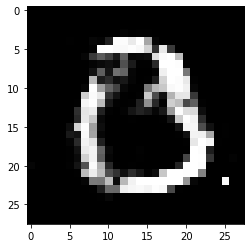

[99/100]: loss_d: 0.649, loss_g: 0.860


In [83]:
discriminator1 = DiscriminatorModel1()
generator1 = GeneratorModel1()
discriminator1.to(device) 
generator1.to(device)
train(generator1, discriminator1, data_loader, model_name='g1_d1')

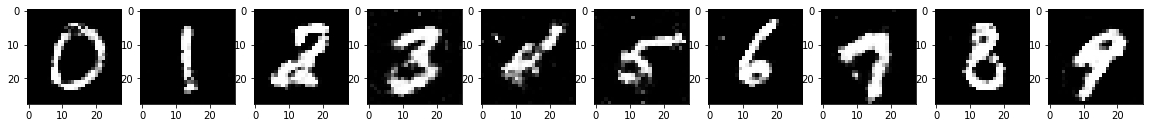

In [93]:
draw_images('g1_d1.pt')

[0/100]: loss_d: 0.584, loss_g: 1.873
[1/100]: loss_d: 0.644, loss_g: 1.276
[2/100]: loss_d: 0.570, loss_g: 1.609
[3/100]: loss_d: 0.622, loss_g: 1.157
[4/100]: loss_d: 0.577, loss_g: 1.697
[5/100]: loss_d: 0.896, loss_g: 1.914
[6/100]: loss_d: 0.461, loss_g: 1.697
[7/100]: loss_d: 0.434, loss_g: 1.614
[8/100]: loss_d: 0.433, loss_g: 1.729
Training Steps Completed:  499
9


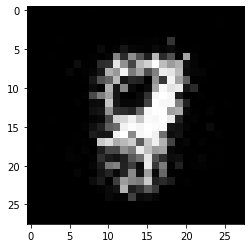

[9/100]: loss_d: 0.382, loss_g: 1.911
[10/100]: loss_d: 0.360, loss_g: 2.115
[11/100]: loss_d: 0.307, loss_g: 2.502
[12/100]: loss_d: 0.264, loss_g: 3.047
[13/100]: loss_d: 0.195, loss_g: 3.820
[14/100]: loss_d: 0.079, loss_g: 5.791
[15/100]: loss_d: 0.061, loss_g: 6.860
[16/100]: loss_d: 0.057, loss_g: 7.376
[17/100]: loss_d: 0.038, loss_g: 8.563
[18/100]: loss_d: 0.012, loss_g: 10.135
Training Steps Completed:  499
3


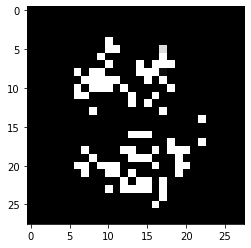

[19/100]: loss_d: 0.007, loss_g: 12.796
[20/100]: loss_d: 0.005, loss_g: 13.022
[21/100]: loss_d: 0.001, loss_g: 15.423
[22/100]: loss_d: 0.001, loss_g: 16.045
[23/100]: loss_d: 0.002, loss_g: 17.636
[24/100]: loss_d: 0.002, loss_g: 18.103
[25/100]: loss_d: 0.002, loss_g: 14.299
[26/100]: loss_d: 0.001, loss_g: 20.154
[27/100]: loss_d: 0.006, loss_g: 16.200
[28/100]: loss_d: 0.000, loss_g: 16.593
Training Steps Completed:  499
4


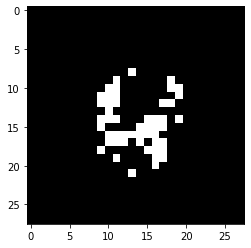

[29/100]: loss_d: 0.000, loss_g: 18.159
[30/100]: loss_d: 0.000, loss_g: 18.392
[31/100]: loss_d: 0.001, loss_g: 21.603
[32/100]: loss_d: 0.002, loss_g: 21.431
[33/100]: loss_d: 0.001, loss_g: 18.867
[34/100]: loss_d: 0.000, loss_g: 19.965
[35/100]: loss_d: 0.000, loss_g: 27.956
[36/100]: loss_d: 0.000, loss_g: 20.473
[37/100]: loss_d: 0.000, loss_g: 21.961
[38/100]: loss_d: 0.000, loss_g: 22.905
Training Steps Completed:  499
3


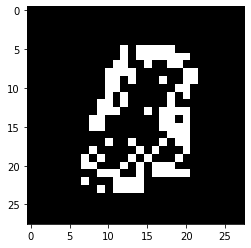

[39/100]: loss_d: 0.000, loss_g: 25.336
[40/100]: loss_d: 0.004, loss_g: 19.616
[41/100]: loss_d: 0.000, loss_g: 19.819
[42/100]: loss_d: 0.001, loss_g: 22.713
[43/100]: loss_d: 0.002, loss_g: 16.201
[44/100]: loss_d: 0.001, loss_g: 15.409
[45/100]: loss_d: 0.000, loss_g: 16.299
[46/100]: loss_d: 0.000, loss_g: 19.480
[47/100]: loss_d: 0.000, loss_g: 19.628
[48/100]: loss_d: 0.001, loss_g: 21.743
Training Steps Completed:  499
0


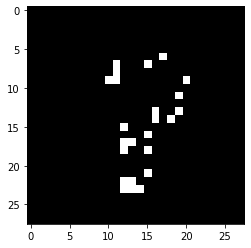

[49/100]: loss_d: 0.000, loss_g: 18.843
[50/100]: loss_d: 0.000, loss_g: 19.265
[51/100]: loss_d: 0.000, loss_g: 22.691
[52/100]: loss_d: 0.002, loss_g: 20.304
[53/100]: loss_d: 0.001, loss_g: 18.294
[54/100]: loss_d: 0.001, loss_g: 19.984
[55/100]: loss_d: 0.002, loss_g: 20.426
[56/100]: loss_d: 0.001, loss_g: 17.581
[57/100]: loss_d: 0.001, loss_g: 19.894
[58/100]: loss_d: 0.000, loss_g: 17.236
Training Steps Completed:  499
6


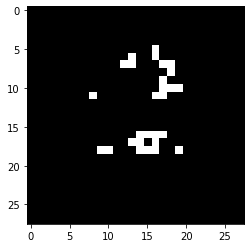

[59/100]: loss_d: 0.000, loss_g: 17.102
[60/100]: loss_d: 0.001, loss_g: 31.109
[61/100]: loss_d: 0.000, loss_g: 22.799
[62/100]: loss_d: 0.000, loss_g: 26.206
[63/100]: loss_d: 0.000, loss_g: 27.589
[64/100]: loss_d: 0.000, loss_g: 24.228
[65/100]: loss_d: 0.000, loss_g: 40.566
[66/100]: loss_d: 0.000, loss_g: 25.485
[67/100]: loss_d: 0.000, loss_g: 19.465
[68/100]: loss_d: 0.000, loss_g: 21.545
Training Steps Completed:  499
5


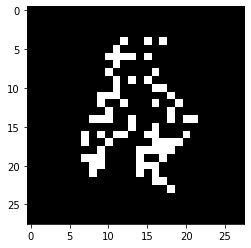

[69/100]: loss_d: 0.000, loss_g: 20.908
[70/100]: loss_d: 0.000, loss_g: 21.213
[71/100]: loss_d: 0.000, loss_g: 22.528
[72/100]: loss_d: 0.001, loss_g: 61.990
[73/100]: loss_d: 0.000, loss_g: 70.933
[74/100]: loss_d: 0.000, loss_g: 70.827
[75/100]: loss_d: 0.000, loss_g: 70.766
[76/100]: loss_d: 0.000, loss_g: 71.053
[77/100]: loss_d: 0.001, loss_g: 57.275
[78/100]: loss_d: 0.001, loss_g: 29.151
Training Steps Completed:  499
3


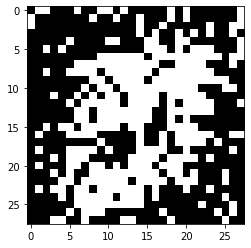

[79/100]: loss_d: 0.000, loss_g: 25.922
[80/100]: loss_d: 0.000, loss_g: 35.847
[81/100]: loss_d: 0.000, loss_g: 35.046
[82/100]: loss_d: 0.002, loss_g: 32.768
[83/100]: loss_d: 0.001, loss_g: 16.735
[84/100]: loss_d: 0.000, loss_g: 19.392
[85/100]: loss_d: 0.000, loss_g: 16.693
[86/100]: loss_d: 0.000, loss_g: 18.225
[87/100]: loss_d: 0.001, loss_g: 29.860
[88/100]: loss_d: 0.000, loss_g: 18.109
Training Steps Completed:  499
6


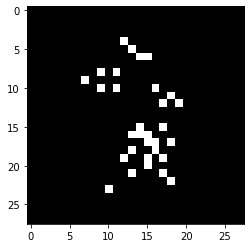

[89/100]: loss_d: 0.000, loss_g: 18.157
[90/100]: loss_d: 0.000, loss_g: 18.695
[91/100]: loss_d: 0.000, loss_g: 19.675
[92/100]: loss_d: 0.000, loss_g: 19.719
[93/100]: loss_d: 0.000, loss_g: 28.653
[94/100]: loss_d: 0.003, loss_g: 35.321
[95/100]: loss_d: 0.003, loss_g: 16.474
[96/100]: loss_d: 0.001, loss_g: 19.662
[97/100]: loss_d: 0.000, loss_g: 22.595
[98/100]: loss_d: 0.000, loss_g: 18.945
Training Steps Completed:  499
7


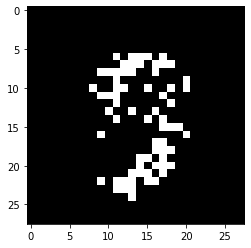

[99/100]: loss_d: 0.000, loss_g: 17.449


In [94]:
discriminator1 = DiscriminatorModel1()
generator2 = GeneratorModel2()
discriminator1.to(device) 
generator2.to(device)
train(generator2, discriminator1, data_loader, model_name='g2_d1')

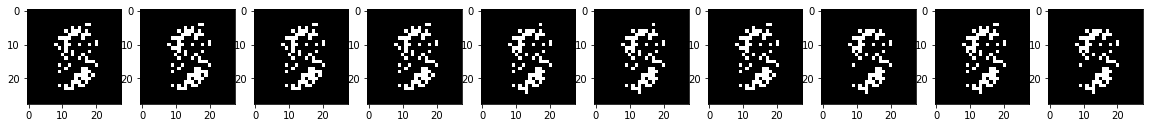

In [95]:
draw_images('g2_d1.pt')

[0/100]: loss_d: 0.503, loss_g: 2.114
[1/100]: loss_d: 0.607, loss_g: 1.330
[2/100]: loss_d: 0.610, loss_g: 1.516
[3/100]: loss_d: 0.579, loss_g: 1.357
[4/100]: loss_d: 0.516, loss_g: 1.438
[5/100]: loss_d: 0.380, loss_g: 2.216
[6/100]: loss_d: 0.331, loss_g: 2.320
[7/100]: loss_d: 0.337, loss_g: 2.156
[8/100]: loss_d: 0.305, loss_g: 2.379
Training Steps Completed:  499
8


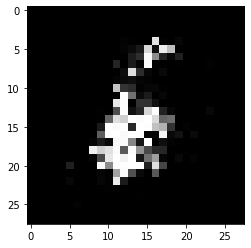

[9/100]: loss_d: 0.281, loss_g: 2.781
[10/100]: loss_d: 0.250, loss_g: 2.853
[11/100]: loss_d: 0.166, loss_g: 3.856
[12/100]: loss_d: 0.104, loss_g: 5.172
[13/100]: loss_d: 0.102, loss_g: 5.319
[14/100]: loss_d: 0.043, loss_g: 7.374
[15/100]: loss_d: 0.007, loss_g: 11.045
[16/100]: loss_d: 0.005, loss_g: 11.792
[17/100]: loss_d: 0.003, loss_g: 12.627
[18/100]: loss_d: 0.003, loss_g: 13.619
Training Steps Completed:  499
1


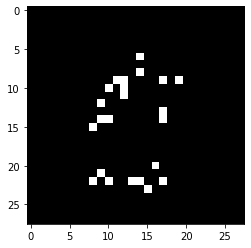

[19/100]: loss_d: 0.001, loss_g: 17.391
[20/100]: loss_d: 0.002, loss_g: 20.670
[21/100]: loss_d: 0.003, loss_g: 16.742
[22/100]: loss_d: 0.000, loss_g: 18.323
[23/100]: loss_d: 0.000, loss_g: 22.494
[24/100]: loss_d: 0.000, loss_g: 23.455
[25/100]: loss_d: 0.000, loss_g: 22.647
[26/100]: loss_d: 0.000, loss_g: 24.103
[27/100]: loss_d: 0.000, loss_g: 25.269
[28/100]: loss_d: 0.009, loss_g: 17.747
Training Steps Completed:  499
2


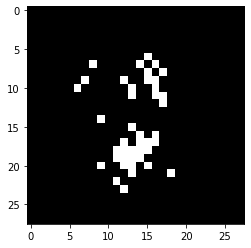

[29/100]: loss_d: 0.002, loss_g: 16.453
[30/100]: loss_d: 0.001, loss_g: 17.032
[31/100]: loss_d: 0.000, loss_g: 18.838
[32/100]: loss_d: 0.000, loss_g: 20.565
[33/100]: loss_d: 0.002, loss_g: 20.902
[34/100]: loss_d: 0.002, loss_g: 16.494
[35/100]: loss_d: 0.000, loss_g: 18.248
[36/100]: loss_d: 0.000, loss_g: 19.985
[37/100]: loss_d: 0.000, loss_g: 21.373
[38/100]: loss_d: 0.000, loss_g: 23.075
Training Steps Completed:  499
8


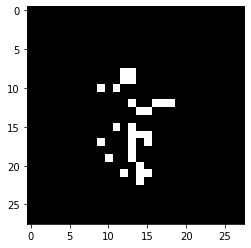

[39/100]: loss_d: 0.001, loss_g: 21.354
[40/100]: loss_d: 0.000, loss_g: 25.245
[41/100]: loss_d: 0.000, loss_g: 21.533
[42/100]: loss_d: 0.000, loss_g: 23.802
[43/100]: loss_d: 0.000, loss_g: 27.323
[44/100]: loss_d: 0.000, loss_g: 27.591
[45/100]: loss_d: 0.000, loss_g: 25.580
[46/100]: loss_d: 0.000, loss_g: 25.413
[47/100]: loss_d: 0.000, loss_g: 26.158
[48/100]: loss_d: 0.000, loss_g: 26.846
Training Steps Completed:  499
7


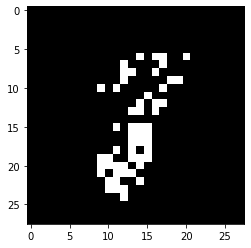

[49/100]: loss_d: 0.000, loss_g: 27.678
[50/100]: loss_d: 0.000, loss_g: 28.017
[51/100]: loss_d: 0.000, loss_g: 28.149
[52/100]: loss_d: 0.000, loss_g: 28.594
[53/100]: loss_d: 0.000, loss_g: 28.860
[54/100]: loss_d: 0.000, loss_g: 28.086
[55/100]: loss_d: 0.000, loss_g: 28.963
[56/100]: loss_d: 0.000, loss_g: 30.539
[57/100]: loss_d: 0.000, loss_g: 30.936
[58/100]: loss_d: 0.000, loss_g: 31.153
Training Steps Completed:  499
9


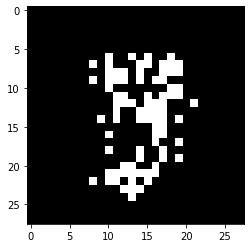

[59/100]: loss_d: 0.004, loss_g: 41.317
[60/100]: loss_d: 0.000, loss_g: 77.263
[61/100]: loss_d: 0.000, loss_g: 76.058
[62/100]: loss_d: 0.000, loss_g: 74.688
[63/100]: loss_d: 0.000, loss_g: 74.868
[64/100]: loss_d: 0.000, loss_g: 75.496
[65/100]: loss_d: 0.000, loss_g: 74.792
[66/100]: loss_d: 0.000, loss_g: 74.812
[67/100]: loss_d: 0.000, loss_g: 73.850
[68/100]: loss_d: 0.000, loss_g: 73.258
Training Steps Completed:  499
3


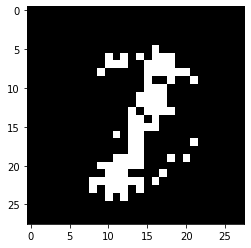

[69/100]: loss_d: 0.003, loss_g: 56.340
[70/100]: loss_d: 0.000, loss_g: 17.004
[71/100]: loss_d: 0.000, loss_g: 18.554
[72/100]: loss_d: 0.000, loss_g: 20.312
[73/100]: loss_d: 0.000, loss_g: 20.827
[74/100]: loss_d: 0.002, loss_g: 18.533
[75/100]: loss_d: 0.000, loss_g: 19.384
[76/100]: loss_d: 0.000, loss_g: 19.128
[77/100]: loss_d: 0.001, loss_g: 18.550
[78/100]: loss_d: 0.000, loss_g: 19.129
Training Steps Completed:  499
9


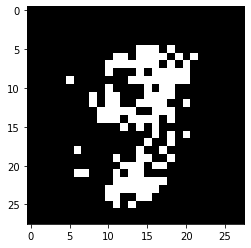

[79/100]: loss_d: 0.000, loss_g: 24.458
[80/100]: loss_d: 0.000, loss_g: 25.844
[81/100]: loss_d: 0.000, loss_g: 26.421
[82/100]: loss_d: 0.000, loss_g: 27.020
[83/100]: loss_d: 0.000, loss_g: 27.237
[84/100]: loss_d: 0.000, loss_g: 28.308
[85/100]: loss_d: 0.001, loss_g: 30.191
[86/100]: loss_d: 0.000, loss_g: 40.825
[87/100]: loss_d: 0.000, loss_g: 41.263
[88/100]: loss_d: 0.000, loss_g: 41.681
Training Steps Completed:  499
1


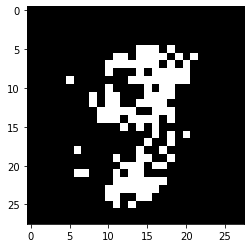

[89/100]: loss_d: 0.000, loss_g: 42.657
[90/100]: loss_d: 0.000, loss_g: 42.452
[91/100]: loss_d: 0.000, loss_g: 42.037
[92/100]: loss_d: 0.000, loss_g: 41.699
[93/100]: loss_d: 0.000, loss_g: 41.617
[94/100]: loss_d: 0.000, loss_g: 41.575
[95/100]: loss_d: 0.000, loss_g: 41.339
[96/100]: loss_d: 0.000, loss_g: 41.320
[97/100]: loss_d: 0.000, loss_g: 41.214
[98/100]: loss_d: 0.000, loss_g: 41.529
Training Steps Completed:  499
3


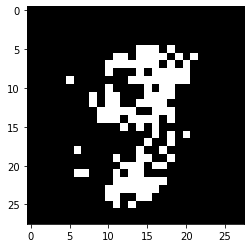

[99/100]: loss_d: 0.000, loss_g: 41.880


In [96]:
discriminator1 = DiscriminatorModel1()
generator3 = GeneratorModel3()
discriminator1.to(device) 
generator3.to(device)
train(generator3, discriminator1, data_loader, model_name='g3_d1')

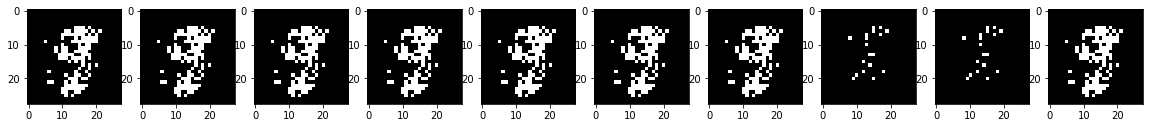

In [97]:
draw_images('g3_d1.pt')

[0/100]: loss_d: 0.476, loss_g: 3.799
[1/100]: loss_d: 0.302, loss_g: 5.088
[2/100]: loss_d: 0.227, loss_g: 7.712
[3/100]: loss_d: 0.212, loss_g: 11.077
[4/100]: loss_d: 0.093, loss_g: 9.156
[5/100]: loss_d: 0.116, loss_g: 6.297
[6/100]: loss_d: 0.086, loss_g: 8.591
[7/100]: loss_d: 0.071, loss_g: 8.278
[8/100]: loss_d: 0.060, loss_g: 10.396
Training Steps Completed:  499
8


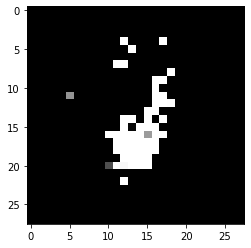

[9/100]: loss_d: 0.068, loss_g: 8.697
[10/100]: loss_d: 0.025, loss_g: 10.595
[11/100]: loss_d: 0.021, loss_g: 12.974
[12/100]: loss_d: 0.006, loss_g: 14.282
[13/100]: loss_d: 0.002, loss_g: 16.761
[14/100]: loss_d: 0.005, loss_g: 33.961
[15/100]: loss_d: 0.001, loss_g: 17.348
[16/100]: loss_d: 0.000, loss_g: 20.065
[17/100]: loss_d: 0.000, loss_g: 23.861
[18/100]: loss_d: 0.000, loss_g: 27.649
Training Steps Completed:  499
2


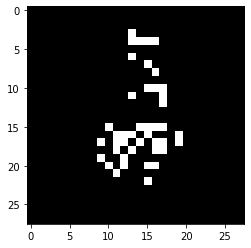

[19/100]: loss_d: 0.000, loss_g: 35.952
[20/100]: loss_d: 0.000, loss_g: 32.849
[21/100]: loss_d: 0.000, loss_g: 33.186
[22/100]: loss_d: 0.000, loss_g: 33.930
[23/100]: loss_d: 0.000, loss_g: 34.300
[24/100]: loss_d: 0.000, loss_g: 34.725
[25/100]: loss_d: 0.000, loss_g: 34.921
[26/100]: loss_d: 0.000, loss_g: 35.051
[27/100]: loss_d: 0.008, loss_g: 35.980
[28/100]: loss_d: 0.002, loss_g: 31.268
Training Steps Completed:  499
6


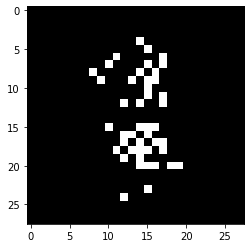

[29/100]: loss_d: 0.000, loss_g: 23.712
[30/100]: loss_d: 0.000, loss_g: 23.980
[31/100]: loss_d: 0.000, loss_g: 24.708
[32/100]: loss_d: 0.000, loss_g: 25.020
[33/100]: loss_d: 0.000, loss_g: 25.545
[34/100]: loss_d: 0.000, loss_g: 26.310
[35/100]: loss_d: 0.000, loss_g: 26.760
[36/100]: loss_d: 0.000, loss_g: 29.498
[37/100]: loss_d: 0.000, loss_g: 28.504
[38/100]: loss_d: 0.000, loss_g: 28.368
Training Steps Completed:  499
2


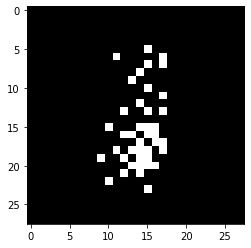

[39/100]: loss_d: 0.000, loss_g: 30.371
[40/100]: loss_d: 0.000, loss_g: 32.885
[41/100]: loss_d: 0.000, loss_g: 31.172
[42/100]: loss_d: 0.000, loss_g: 31.189
[43/100]: loss_d: 0.000, loss_g: 30.927
[44/100]: loss_d: 0.000, loss_g: 30.858
[45/100]: loss_d: 0.000, loss_g: 31.848
[46/100]: loss_d: 0.000, loss_g: 32.540
[47/100]: loss_d: 0.000, loss_g: 33.272
[48/100]: loss_d: 0.000, loss_g: 33.477
Training Steps Completed:  499
7


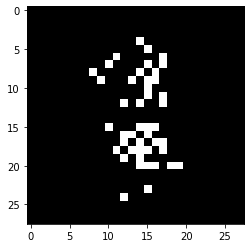

[49/100]: loss_d: 0.000, loss_g: 33.567
[50/100]: loss_d: 0.000, loss_g: 33.975
[51/100]: loss_d: 0.000, loss_g: 35.778
[52/100]: loss_d: 0.000, loss_g: 36.104
[53/100]: loss_d: 0.000, loss_g: 37.232
[54/100]: loss_d: 0.000, loss_g: 36.700
[55/100]: loss_d: 0.000, loss_g: 36.385
[56/100]: loss_d: 0.000, loss_g: 37.765
[57/100]: loss_d: 0.000, loss_g: 40.585
[58/100]: loss_d: 0.000, loss_g: 41.361
Training Steps Completed:  499
4


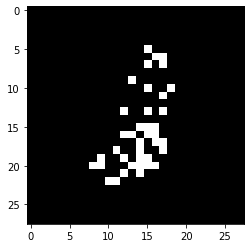

[59/100]: loss_d: 0.000, loss_g: 41.791
[60/100]: loss_d: 0.000, loss_g: 41.941
[61/100]: loss_d: 0.000, loss_g: 42.022
[62/100]: loss_d: 0.000, loss_g: 42.160
[63/100]: loss_d: 0.000, loss_g: 42.694
[64/100]: loss_d: 0.000, loss_g: 42.378
[65/100]: loss_d: 0.000, loss_g: 42.798
[66/100]: loss_d: 0.000, loss_g: 51.155
[67/100]: loss_d: 0.000, loss_g: 51.288
[68/100]: loss_d: 0.000, loss_g: 49.468
Training Steps Completed:  499
3


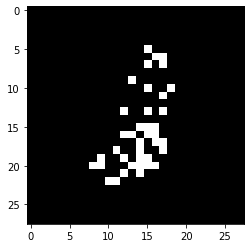

[69/100]: loss_d: 0.000, loss_g: 49.120
[70/100]: loss_d: 0.000, loss_g: 48.653
[71/100]: loss_d: 0.000, loss_g: 48.923
[72/100]: loss_d: 0.000, loss_g: 49.796
[73/100]: loss_d: 0.000, loss_g: 49.670
[74/100]: loss_d: 0.000, loss_g: 49.684
[75/100]: loss_d: 0.000, loss_g: 49.704
[76/100]: loss_d: 0.000, loss_g: 49.511
[77/100]: loss_d: 0.000, loss_g: 49.500
[78/100]: loss_d: 0.000, loss_g: 49.524
Training Steps Completed:  499
3


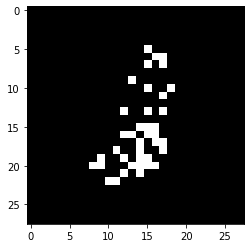

[79/100]: loss_d: 0.000, loss_g: 49.507
[80/100]: loss_d: 0.000, loss_g: 49.629
[81/100]: loss_d: 0.000, loss_g: 49.569
[82/100]: loss_d: 0.000, loss_g: 49.514
[83/100]: loss_d: 0.000, loss_g: 46.888
[84/100]: loss_d: 0.000, loss_g: 49.180
[85/100]: loss_d: 0.000, loss_g: 49.145
[86/100]: loss_d: 0.000, loss_g: 49.203
[87/100]: loss_d: 0.000, loss_g: 49.113
[88/100]: loss_d: 0.000, loss_g: 49.241
Training Steps Completed:  499
0


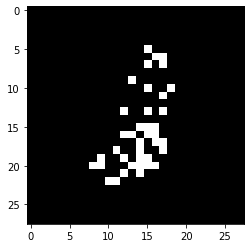

[89/100]: loss_d: 0.000, loss_g: 49.231
[90/100]: loss_d: 0.000, loss_g: 49.279
[91/100]: loss_d: 0.000, loss_g: 49.337
[92/100]: loss_d: 0.000, loss_g: 49.263
[93/100]: loss_d: 0.000, loss_g: 49.322
[94/100]: loss_d: 0.000, loss_g: 49.374
[95/100]: loss_d: 0.000, loss_g: 49.449
[96/100]: loss_d: 0.000, loss_g: 49.650
[97/100]: loss_d: 0.000, loss_g: 49.715
[98/100]: loss_d: 0.000, loss_g: 49.942
Training Steps Completed:  499
0


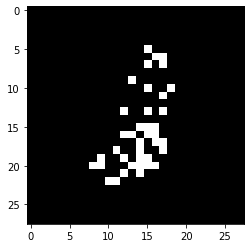

[99/100]: loss_d: 0.000, loss_g: 49.939


In [98]:
discriminator1 = DiscriminatorModel1()
generator4 = GeneratorModel4()
discriminator1.to(device) 
generator4.to(device)
train(generator4, discriminator1, data_loader, model_name='g4_d1')

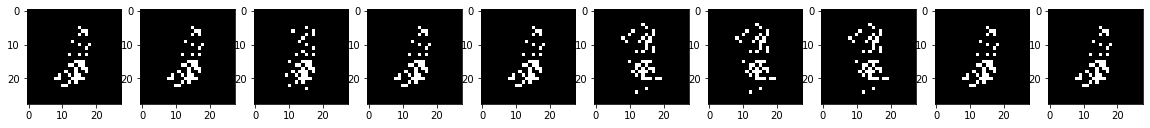

In [99]:
draw_images('g4_d1.pt')

[0/100]: loss_d: 0.131, loss_g: 7.095
[1/100]: loss_d: 0.341, loss_g: 4.476
[2/100]: loss_d: 0.359, loss_g: 3.919
[3/100]: loss_d: 0.203, loss_g: 4.146
[4/100]: loss_d: 0.177, loss_g: 3.898
[5/100]: loss_d: 0.167, loss_g: 3.858
[6/100]: loss_d: 0.175, loss_g: 3.915
[7/100]: loss_d: 0.222, loss_g: 3.399
[8/100]: loss_d: 0.236, loss_g: 3.176
Training Steps Completed:  499
3


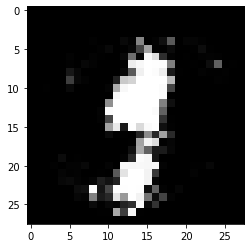

[9/100]: loss_d: 0.281, loss_g: 2.751
[10/100]: loss_d: 0.334, loss_g: 2.439
[11/100]: loss_d: 0.358, loss_g: 2.172
[12/100]: loss_d: 0.374, loss_g: 2.103
[13/100]: loss_d: 0.379, loss_g: 2.075
[14/100]: loss_d: 0.413, loss_g: 1.883
[15/100]: loss_d: 0.402, loss_g: 1.898
[16/100]: loss_d: 0.420, loss_g: 1.825
[17/100]: loss_d: 0.419, loss_g: 1.816
[18/100]: loss_d: 0.456, loss_g: 1.645
Training Steps Completed:  499
5


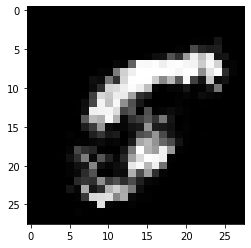

[19/100]: loss_d: 0.466, loss_g: 1.578
[20/100]: loss_d: 0.471, loss_g: 1.554
[21/100]: loss_d: 0.472, loss_g: 1.555
[22/100]: loss_d: 0.498, loss_g: 1.422
[23/100]: loss_d: 0.502, loss_g: 1.406
[24/100]: loss_d: 0.508, loss_g: 1.359
[25/100]: loss_d: 0.519, loss_g: 1.362
[26/100]: loss_d: 0.528, loss_g: 1.315
[27/100]: loss_d: 0.537, loss_g: 1.253
[28/100]: loss_d: 0.541, loss_g: 1.251
Training Steps Completed:  499
6


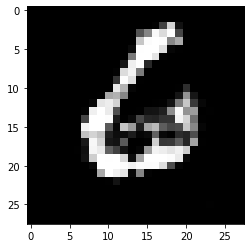

[29/100]: loss_d: 0.545, loss_g: 1.244
[30/100]: loss_d: 0.547, loss_g: 1.237
[31/100]: loss_d: 0.563, loss_g: 1.164
[32/100]: loss_d: 0.554, loss_g: 1.187
[33/100]: loss_d: 0.565, loss_g: 1.154
[34/100]: loss_d: 0.571, loss_g: 1.133
[35/100]: loss_d: 0.565, loss_g: 1.147
[36/100]: loss_d: 0.575, loss_g: 1.114
[37/100]: loss_d: 0.575, loss_g: 1.113
[38/100]: loss_d: 0.576, loss_g: 1.095
Training Steps Completed:  499
5


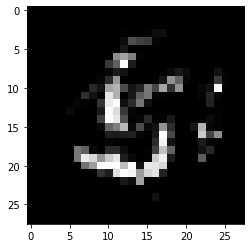

[39/100]: loss_d: 0.581, loss_g: 1.094
[40/100]: loss_d: 0.577, loss_g: 1.112
[41/100]: loss_d: 0.590, loss_g: 1.060
[42/100]: loss_d: 0.589, loss_g: 1.055
[43/100]: loss_d: 0.584, loss_g: 1.088
[44/100]: loss_d: 0.583, loss_g: 1.083
[45/100]: loss_d: 0.596, loss_g: 1.035
[46/100]: loss_d: 0.605, loss_g: 1.007
[47/100]: loss_d: 0.605, loss_g: 1.002
[48/100]: loss_d: 0.608, loss_g: 0.991
Training Steps Completed:  499
5


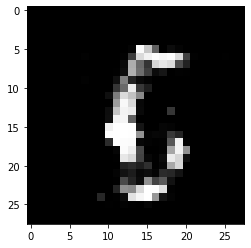

[49/100]: loss_d: 0.608, loss_g: 0.992
[50/100]: loss_d: 0.607, loss_g: 0.997
[51/100]: loss_d: 0.609, loss_g: 0.984
[52/100]: loss_d: 0.613, loss_g: 0.977
[53/100]: loss_d: 0.611, loss_g: 0.983
[54/100]: loss_d: 0.613, loss_g: 0.967
[55/100]: loss_d: 0.616, loss_g: 0.968
[56/100]: loss_d: 0.613, loss_g: 0.980
[57/100]: loss_d: 0.620, loss_g: 0.951
[58/100]: loss_d: 0.611, loss_g: 0.967
Training Steps Completed:  499
4


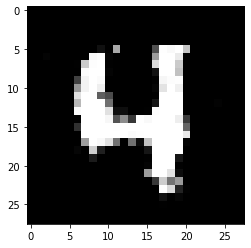

[59/100]: loss_d: 0.624, loss_g: 0.937
[60/100]: loss_d: 0.624, loss_g: 0.938
[61/100]: loss_d: 0.625, loss_g: 0.928
[62/100]: loss_d: 0.621, loss_g: 0.949
[63/100]: loss_d: 0.627, loss_g: 0.917
[64/100]: loss_d: 0.628, loss_g: 0.921
[65/100]: loss_d: 0.627, loss_g: 0.924
[66/100]: loss_d: 0.628, loss_g: 0.927
[67/100]: loss_d: 0.628, loss_g: 0.913
[68/100]: loss_d: 0.630, loss_g: 0.916
Training Steps Completed:  499
3


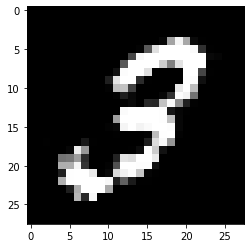

[69/100]: loss_d: 0.626, loss_g: 0.927
[70/100]: loss_d: 0.626, loss_g: 0.934
[71/100]: loss_d: 0.621, loss_g: 0.946
[72/100]: loss_d: 0.633, loss_g: 0.895
[73/100]: loss_d: 0.642, loss_g: 0.872
[74/100]: loss_d: 0.637, loss_g: 0.895
[75/100]: loss_d: 0.634, loss_g: 0.911
[76/100]: loss_d: 0.637, loss_g: 0.899
[77/100]: loss_d: 0.623, loss_g: 0.951
[78/100]: loss_d: 0.631, loss_g: 0.912
Training Steps Completed:  499
7


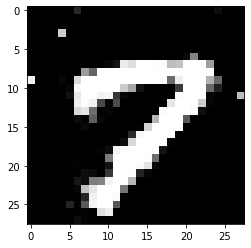

[79/100]: loss_d: 0.638, loss_g: 0.892
[80/100]: loss_d: 0.641, loss_g: 0.883
[81/100]: loss_d: 0.639, loss_g: 0.885
[82/100]: loss_d: 0.642, loss_g: 0.877
[83/100]: loss_d: 0.648, loss_g: 0.857
[84/100]: loss_d: 0.640, loss_g: 0.889
[85/100]: loss_d: 0.641, loss_g: 0.882
[86/100]: loss_d: 0.640, loss_g: 0.887
[87/100]: loss_d: 0.642, loss_g: 0.877
[88/100]: loss_d: 0.641, loss_g: 0.898
Training Steps Completed:  499
1


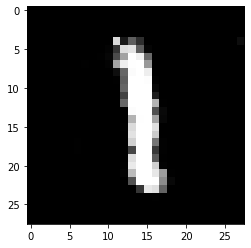

[89/100]: loss_d: 0.643, loss_g: 0.871
[90/100]: loss_d: 0.647, loss_g: 0.865
[91/100]: loss_d: 0.647, loss_g: 0.870
[92/100]: loss_d: 0.643, loss_g: 0.866
[93/100]: loss_d: 0.646, loss_g: 0.859
[94/100]: loss_d: 0.648, loss_g: 0.857
[95/100]: loss_d: 0.648, loss_g: 0.867
[96/100]: loss_d: 0.644, loss_g: 0.874
[97/100]: loss_d: 0.649, loss_g: 0.855
[98/100]: loss_d: 0.646, loss_g: 0.872
Training Steps Completed:  499
4


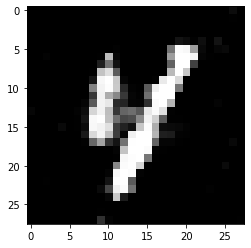

[99/100]: loss_d: 0.649, loss_g: 0.848


In [100]:
discriminator2 = DiscriminatorModel2()
generator1 = GeneratorModel1()
discriminator2.to(device) 
generator1.to(device)
train(generator1, discriminator2, data_loader, model_name='g1_d2')

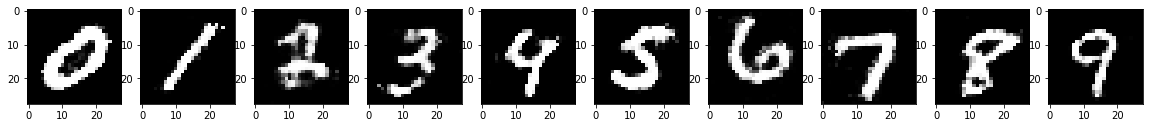

In [101]:
draw_images('g1_d2.pt')